# Numba
Python optimisation library
http://numba.pydata.org/

Workthrough of examples from: https://gist.github.com/safijari/fa4eba922cea19b3bc6a693fe2a97af7 (used in https://www.youtube.com/watch?v=x58W9A2lnQc)

## Numba is:
- a 'just-in-time' compiler
- works well with numpy arrays
- allows you to speed-up and parallelise algorithms

### Key take aways to remember
- numba does not like lists, use numba 'typed lists' or arrays
- preallocate the output array size in the function
- use `njit()` to be aware if functions are reverting to python (e.g. due to dtype problems)
- to use multiple threads remember to also set `nogil=True`

## The nuts and bolts
Numba is a 'just-in-time' compiler. The first time a function is run with numba it 'compiles' the function. This means:
    - the first run will take longer due to the compilation process (maybe even than the original function without numba)
    - subsequent runs however will be much faster

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numba import jit, njit, types, vectorize

In [3]:
def original_function(input_list):
    output_list = []
    for item in input_list:
        if item % 2 == 0:
            output_list.append(2)
        else:
            output_list.append('1')
    return output_list

test_list = list(range(100000))

### dtypes
The function above delibrately produces a list with mixed dtypes.

Python happily mixes dtypes in lists. The numba `jit` function cannot do this. The function won't fail but it will not be optimised. Numba will default to 'object mode' which allows it to process the funtion similarly to the original python code, losing any advantages in processing time. 

In [4]:
%%time
original_function(test_list)[0:10]

CPU times: user 10.8 ms, sys: 661 µs, total: 11.5 ms
Wall time: 11.2 ms


[2, '1', 2, '1', 2, '1', 2, '1', 2, '1']

In [5]:
jitted_function = jit()(original_function)

In [6]:
%%time
jitted_function(test_list)[0:10]

CPU times: user 313 ms, sys: 16.7 ms, total: 329 ms
Wall time: 341 ms


[2, '1', 2, '1', 2, '1', 2, '1', 2, '1']

In [7]:
%%time
jitted_function(test_list)[0:10]

CPU times: user 33.9 ms, sys: 528 µs, total: 34.5 ms
Wall time: 34.4 ms


[2, '1', 2, '1', 2, '1', 2, '1', 2, '1']

To return a true error instead of a warning you can set `nopython` to `True`. Or use the `njit` decorator which sets this as default. 

This helps prevent any inefficient code being sent to production.

In [8]:
#option 1
jitted_function = jit(nopython=True)(original_function)

In [9]:
#option 2
jitted_function = njit()(original_function)

In [10]:
jitted_function(test_list)[0:10]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of BoundFunction(list.append for list(int64)<iv=None>) with parameters (Literal[str](1))

During: resolving callee type: BoundFunction(list.append for list(int64)<iv=None>)
During: typing of call at /var/folders/kj/wptb3bg14g7c1hb01sd555sc0000gn/T/ipykernel_3152/1571162156.py (7)


File "../../../../../var/folders/kj/wptb3bg14g7c1hb01sd555sc0000gn/T/ipykernel_3152/1571162156.py", line 7:
<source missing, REPL/exec in use?>


### Lists
You should avoid using python lists with numba wherever possible,use numpy arrays or the numba typed list instead. Numba requires as additional 'reflection' step to determine what is happening in a list which again slows down processing time.

This is demonstrated below where we now pass only integers to the list but the jitted function is still slower than the base function itself. 

- https://numba.pydata.org/numba-doc/dev/reference/pysupported.html#list
- https://numba.readthedocs.io/en/stable/reference/pysupported.html?highlight=list#typed-list

In [11]:
def modified_function(input_list):
    output_list = []
    for item in input_list:
        if item % 2 == 0:
            output_list.append(2)
        else:
            output_list.append(1)
    return output_list

test_list = list(range(100000))

In [12]:
%%time
modified_function(test_list)[0:10]

CPU times: user 8.6 ms, sys: 245 µs, total: 8.84 ms
Wall time: 8.84 ms


[2, 1, 2, 1, 2, 1, 2, 1, 2, 1]

In [13]:
jitted_function = jit()(modified_function)

In [14]:
%%time
jitted_function(test_list)[0:10]

CPU times: user 198 ms, sys: 3.88 ms, total: 202 ms
Wall time: 202 ms


[2, 1, 2, 1, 2, 1, 2, 1, 2, 1]

Changing the function to use a numpy array instead (N.B. this actually slows down the original function)

In [15]:
def modified_function(input_list):
    output_list = []
    for item in input_list:
        if item % 2 == 0:
            output_list.append(2)
        else:
            output_list.append(1)
    return output_list

test_array = np.arange(100000)

In [16]:
%%time
modified_function(test_array)[0:10]

CPU times: user 41.7 ms, sys: 1.76 ms, total: 43.5 ms
Wall time: 48.9 ms


[2, 1, 2, 1, 2, 1, 2, 1, 2, 1]

In [17]:
jitted_function = jit()(modified_function)

In [18]:
%%time
jitted_function(test_array)[0:10] 
#run more than once to see time after compilation

CPU times: user 68.6 ms, sys: 2.53 ms, total: 71.1 ms
Wall time: 71.2 ms


[2, 1, 2, 1, 2, 1, 2, 1, 2, 1]

### Vectorise
Allows you to rewrite a function as a scalar computation. The function is written to run on a single element but we can call this on an array (seems similar to a lambda fuction). 

The first time we call this function it will take an extra long time, as numba is unsure of what size output list to create. The second run numba will optimise this, significantly dropping the processing time. 

In [19]:
@vectorize(nopython=True)
def non_list_function(item):
    if item % 2 == 0:
        return 2
    else:
        return 1

In [20]:
%%time
non_list_function(test_array)

CPU times: user 41.3 ms, sys: 1.81 ms, total: 43.1 ms
Wall time: 42.2 ms


array([2, 1, 2, ..., 1, 2, 1])

In [21]:
%%time
non_list_function(test_array)

CPU times: user 481 µs, sys: 460 µs, total: 941 µs
Wall time: 573 µs


array([2, 1, 2, ..., 1, 2, 1])

We can modify the original function to act like vectorise by setting the size of the output (in this example setting the output array size based on the input array size. The second run demonstrates similar speed improvements to vectorise. 

In [22]:
@njit
def allocated_func(input_list):
    output_list = np.zeros_like(input_list)
    for ii, item in enumerate(input_list):
        if item % 2 == 0:
            output_list[ii] = 2
        else:
            output_list[ii] = 1
    return output_list


In [23]:
%%time
allocated_func(test_array)[0:10]

CPU times: user 102 ms, sys: 7.04 ms, total: 109 ms
Wall time: 115 ms


array([2, 1, 2, 1, 2, 1, 2, 1, 2, 1])

In [24]:
%%time
allocated_func(test_array)[0:10] 

CPU times: user 254 µs, sys: 294 µs, total: 548 µs
Wall time: 838 µs


array([2, 1, 2, 1, 2, 1, 2, 1, 2, 1])

### Threads
To further increase numba performance we can request that it runs using more than one thread. 

First we define a function to simulate a spring-mass-damper system with wet and dry friction. 

In [25]:
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

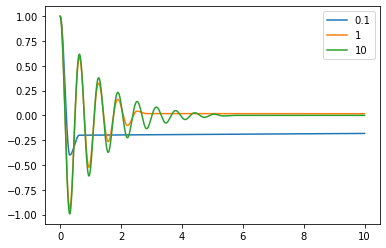

In [26]:
plot(*simulate_spring_mass_funky_damper(0.1))
plot(*simulate_spring_mass_funky_damper(1))
plot(*simulate_spring_mass_funky_damper(10))
legend(['0.1', '1', '10'])

In [27]:
%time _ = simulate_spring_mass_funky_damper(0.1)

CPU times: user 178 ms, sys: 1.44 ms, total: 180 ms
Wall time: 179 ms


Now we use numba and add njit decorators.

In [29]:
@njit
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

#compile
_ = simulate_spring_mass_funky_damper(0.1)

In [30]:
%time _ = simulate_spring_mass_funky_damper(0.1)

CPU times: user 1.51 ms, sys: 329 µs, total: 1.84 ms
Wall time: 1.84 ms


This decreases the runtime significantly.

Now we also employ multiple threads. N.B. that by default numba does not release the 'global interpreter lock' or 'GIL' so we have to also explicitly request this in the function, when we use the `ThreadPoolExecutor`.

Side note: GIL
- https://wiki.python.org/moin/GlobalInterpreterLock
- https://python.land/python-concurrency/the-python-gil
> "In CPython, the global interpreter lock, or GIL, is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once. The GIL prevents race conditions and ensures thread safety"

In [31]:
@njit(nogil=True)
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit(nogil=True)
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

# compile
_ = simulate_spring_mass_funky_damper(0.1)

In [32]:
%%time
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(8) as ex:
    ex.map(simulate_spring_mass_funky_damper, np.arange(0, 1000, 0.1))


CPU times: user 10.3 s, sys: 231 ms, total: 10.6 s
Wall time: 2.13 s


Now we have run the function 1000 times in just over 2 seconds!

We don't actually have to call the `ThreadPoolExecutor` directly and can instead setup a wrapper to do this for us. This wrapper must set the `nogil=True, parallel=True` parameters and include the `prange` function which asks numba to run the function in parallel if possible to do so. 

In [33]:
from numba import prange
@njit(nogil=True, parallel=True)
def run_sims(end=1000):
    for x0 in prange(int(end/0.1)):
        if x0 == 0:
            continue
        simulate_spring_mass_funky_damper(x0*0.1)
        
run_sims(10)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [34]:
%%time
run_sims(1000)

CPU times: user 9.97 s, sys: 149 ms, total: 10.1 s
Wall time: 1.46 s


### Numba and pandas
https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html#numba-jit-compilation

Some pandas methods offer a `engine="numba"` keyword, to enable it directly. If defining your own python function, pandas dataframes or series should be transformed to numpy arrays using `to_numpy()`. 

The pandas website suggests that numba performs best when handling with 1 million + datapoints. Numba is best applied to numerical operations on arrays, as any unsupported function will revert to the slow `object mode`. 

#### Pandas methods with built-in numba
As for all numba function, when run the first time these fucntions will be slower due to compilation. All methods with the `engine="numba"` keyword also have a `engine_kwargs` keyword which takes a dictionary of parameters for the `@jot` decorator. By default the parameters are:
`{"nogil": False, "nopython": True, "parallel": False}`

Methods that can be used with numba include:
- groupby
- window
- expanding
- rolling

In [51]:
data = pd.Series(range(1_00))  # noqa: E225

roll = data.rolling(10)

def f(x):
    return np.sum(x) + 5

    
# # Run the first time, compilation time will affect performance
%timeit -r 1 -n 1 roll.apply(f, engine='numba', raw=True)

# # Function is cached and performance will improve
%timeit roll.apply(f, engine='numba', raw=True)

%timeit roll.apply(f, engine='cython', raw=True)

178 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
71.1 µs ± 2.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
361 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
import numba

def double_every_value_nonumba(x):
    return x * 2

@numba.vectorize
def double_every_value_withnumba(x):  # noqa E501
    return x * 2

In [56]:
# Normal way to make this calculation without a function
%timeit output = data * 2

# Custom function without numba (slower than the normal way)
%timeit output = data.apply(double_every_value_nonumba)

# # Custom function with numba (much faster than both)
%timeit output = double_every_value_withnumba(data.to_numpy())

32 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
94.2 µs ± 4.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.6 µs ± 3.47 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
